**_Note: In order to utilize GitHub actions please FORK the repository as opposed to cloning_**

### Setup Conda Virtual Environment

IMPORTANT: Populate ```.env``` file in the home directory of your repository. Use the [.sample.env](.sample.env) as a reference guide.

In [ ]:
from dotenv import load_dotenv, find_dotenv
import subprocess
import os

load_dotenv(find_dotenv(), override=True)
print(os.getenv('AZURE_OPENAI_ENDPOINT'))

From the home directory run the folloing bash commands

```bash 
conda env create --name llmops --file=./conda.yaml
```  

```bash
conda activate llmops
```

### Get a Handle to the AML Workspace

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import AmlCompute


# authenticate
credential = DefaultAzureCredential(tenantid=os.environ.get('TENANT_ID'))

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

### Create Local PromptFlow Connection to AOAI

In [ ]:
# Note: Optional (only needed for local development/testing)

api_key = os.getenv("AZURE_OPENAI_KEY")
api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
name = "aoai-connect"

command = f"pf connection create --file src/promptflows/connections/connect_aoai.yaml --set api_key={api_key} api_base={api_base} --name {name}"
result = subprocess.run(command,
                        shell=True,
                        check=True,
                        text=True,
                        capture_output=True)

print(result.stdout)

In [ ]:
!pf connection list

### Create a Remote Connection to AOAI

Navigate to the Azure Machine Learning Workspace --> Promptflow --> connections --> Create
Then follow the steps to create a connection

**IMPORTANT:** Name your connection 'aoai-connect'

In [ ]:
## NOT YET SUPPORTED ##
'''
from promptflow.azure import PFClient
from promptflow.entities import AzureOpenAIConnection

pf = PFClient(credential=DefaultAzureCredential(),
              subscription_id=os.environ.get('SUBSCRIPTION_ID'),
              resource_group_name=os.environ.get('RESOURCE_GROUP_NAME'),
               workspace_name=os.environ.get('WORKSPACE_NAME')
             )

aoai_connection = AzureOpenAIConnection(api_base=os.environ.get('AZURE_OPENAI_ENDPOINT'), 
                                        api_key=os.environ.get('AZURE_OPENAI_API_KEY'), 
                                        name="aoai-connect", 
                                        api_type = "azure", 
                                        api_version="2024-02-01"
                                        )

result = pf.connections.create_or_update(aoai_connection)
print(result)
'''

### Setup Service Principal for Github Actions

In [ ]:
subscription_id = os.getenv("SUBSCRIPTION_ID")
resource_group_name = os.getenv("RESOURCE_GROUP_NAME")
role_name = "github_action_role"

command = f"az ad sp create-for-rbac --name {role_name} --role contributor --scopes /subscriptions/{subscription_id}/resourceGroups/{resource_group_name} --json-auth"
print(command)
result = subprocess.run(command,
                        shell=True,
                        check=True,
                        text=True,
                        capture_output=True)

print(result.stdout)

Copy the above^ JSON output and add as a secret in GitHub Secrets. Got to GitHub --> Settings --> Security --> Secrets and Variables --> Actions.  
Add a new repository secret with the name AZURE_CREDENTIALS. Paste the json as the value and save.

[Link to Documentation](https://learn.microsoft.com/en-us/azure/developer/github/connect-from-azure?tabs=azure-cli%2Cwindows#add-the-service-principal-as-a-github-secret)

Add other secrets required to your Github repository. Your end result should look like this:
  
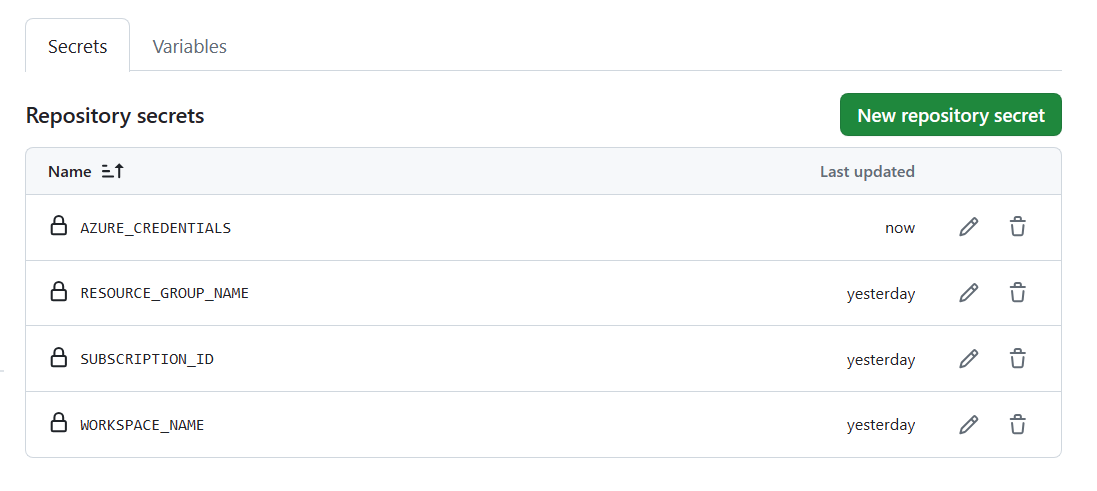

### Create a Remote Compute Target

In [ ]:
# Create Compute Target

# Name assigned to the compute cluster
cpu_compute_target = "remote-cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is.")

except Exception:
    print("Creating a new cpu compute target...")
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        type="amlcompute",
        size="STANDARD_DS3_V2",
        min_instances=0,
        max_instances=1,
        idle_time_before_scale_down=300, # 5 minutes
        tier="Dedicated",
    )
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

print(cpu_cluster)